In [1]:
#Librerias
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense,MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Conv2D,MaxPool2D,Dense,Activation,Flatten,ZeroPadding2D,AveragePooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import *
from tensorflow.keras.preprocessing import image
import seaborn as sns
import glob as gb
import shutil
import os


In [5]:
# Codigo para grafica de barras 
carpeta = 'dataset'

num_arch = {}
for raiz,dirs, archivos in os.walk(carpeta):
    if raiz != 'dataset':
        num_archivos = len(archivos)
        num_arch[raiz] = num_archivos

for subcarpeta, num_archivos in num_arch.items():
    print(f'{subcarpeta}: {num_archivos} archivos')

Text(0.5, 1.0, 'Número de imágenes por género')

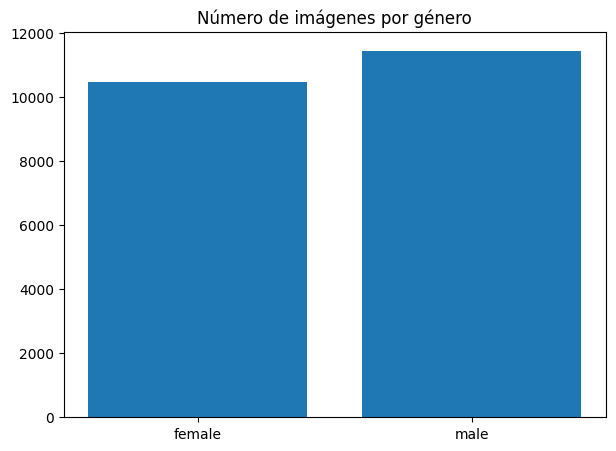

In [13]:
carpetas = list(num_arch.keys())
numeros_archivos = list(num_arch.values())
test = ['female','male']

frequency, bins = np.histogram(numeros_archivos, bins=10)
fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(test,numeros_archivos)
plt.title('Número de imágenes por género')

In [7]:
#Preparación de los datos y aumento de datos
nbatch = 128

data_with_aug = ImageDataGenerator(horizontal_flip=True,rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,vertical_flip=False,rescale = 1./255,validation_split=0.1) #Aumento de datos

training_set = data_with_aug.flow_from_directory('genderDataset/dataset/',
                                                 target_size=(200,200),
                                                 batch_size =nbatch,
                                                 class_mode = 'binary',subset="training")

val = data_with_aug.flow_from_directory('genderDataset/dataset/',
                                          class_mode="binary",
                                          target_size=(200, 200),
                                          batch_size=nbatch,
                                          subset="validation"
                                          )

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory('genderDataset/test/',
                                               class_mode="binary",
                                               target_size=(200,200),
                                               batch_size=nbatch,
                                               shuffle=False)

Found 19696 images belonging to 2 classes.
Found 2187 images belonging to 2 classes.
Found 1825 images belonging to 2 classes.


In [11]:
training_set.class_indices

{'female': 0, 'male': 1}

In [2]:
#Modelo convolocional compuesto por 5 capas convolucionales, una capa totalmente conectada de 512 neuronas, capa Dropout y salida con activacion softmax.
model = Sequential()

model.add(Conv2D(filters =64, kernel_size = (6,6), padding = "Same", activation = "relu", input_shape = (200,200,3)))
model.add(AveragePooling2D(2,2))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(AveragePooling2D(2,2))

model.add(Conv2D(256,(3,3),activation="relu"))
model.add(AveragePooling2D(2,2))

model.add(Conv2D(512,(3,3),activation="relu"))
model.add(AveragePooling2D(2,2))

model.add(Conv2D(512,(3,3),activation="relu"))
model.add(GlobalAveragePooling2D())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(2))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      6976      
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 64)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 49, 49, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 256)       295168    
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 256)      0

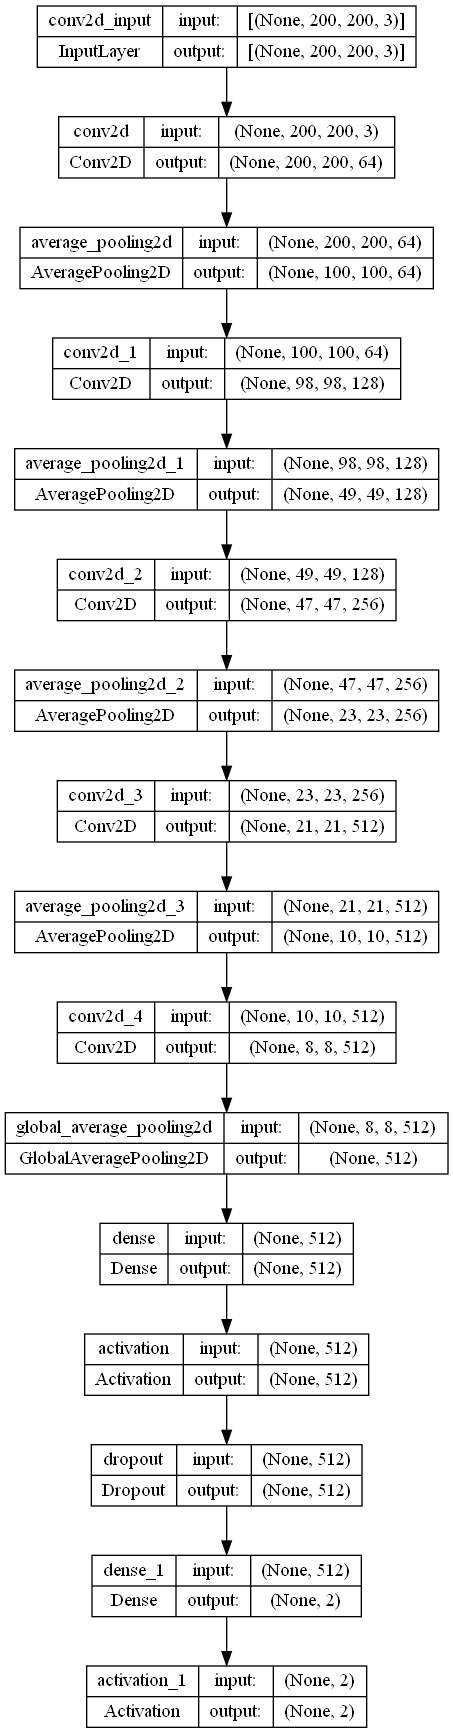

In [4]:
#Grafica del modelo
tf.keras.utils.plot_model(model, to_file='convGenderModel.png', show_shapes=True)

In [4]:
#Learning rate que decae
def scheduler(epoch, lr):
    if epoch < 10:
        return 0.001
    else:
        return lr * tf.math.exp(-0.1)

In [5]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [6]:
#Entrenamiento
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
checkpoint_filepath = 'modelos/clasificadorGenero/model2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
hist =  model.fit(training_set,
                    epochs=20,
                    callbacks=[lr_callbacks,model_checkpoint_callback],
                    validation_data=val)

Epoch 1/20
154/154 [==============================] - 163s 866ms/step - loss: 0.6836 - accuracy: 0.5499 - val_loss: 0.7416 - val_accuracy: 0.5071 - lr: 0.0010
Epoch 2/20
154/154 [==============================] - 125s 805ms/step - loss: 0.6136 - accuracy: 0.6584 - val_loss: 0.6783 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 3/20
154/154 [==============================] - 118s 764ms/step - loss: 0.5520 - accuracy: 0.7169 - val_loss: 0.6500 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 4/20
154/154 [==============================] - 99s 643ms/step - loss: 0.4826 - accuracy: 0.7722 - val_loss: 0.7361 - val_accuracy: 0.5766 - lr: 0.0010
Epoch 5/20
154/154 [==============================] - 103s 666ms/step - loss: 0.4160 - accuracy: 0.8160 - val_loss: 1.0201 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 6/20
154/154 [==============================] - 100s 643ms/step - loss: 0.3818 - accuracy: 0.8344 - val_loss: 0.6650 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 7/20
154/154 [===========================

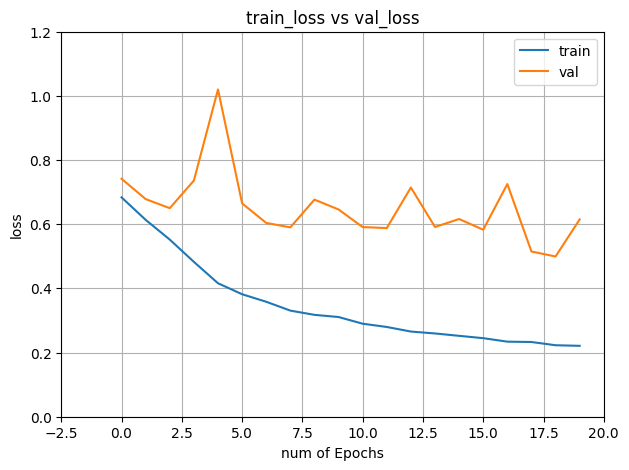

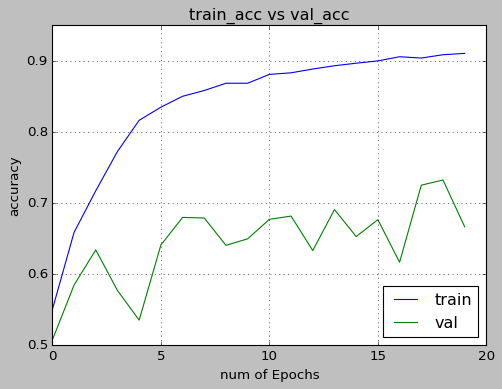

In [7]:
#Obtención de gráficas de entrenamiento
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [4]:
model.load_weights('modelos/clasificadorGenero/model2.h5')

In [9]:
#Obtención de resultados del modelo
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

cf_matrix = confusion_matrix(test_set.classes, y_pred)

print(classification_report(test_set.classes,y_pred,target_names=('female','male')))

15/15 [==============================] - 2s 109ms/step
              precision    recall  f1-score   support

      female       0.89      0.85      0.86       871
        male       0.86      0.90      0.88       954

    accuracy                           0.87      1825
   macro avg       0.87      0.87      0.87      1825
weighted avg       0.87      0.87      0.87      1825



15/15 [==============================] - 1s 97ms/step


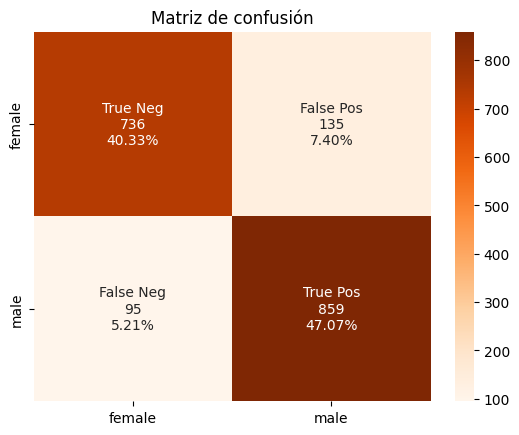

In [23]:
#Obtención de la matriz de confusión
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges',xticklabels=('female','male'),yticklabels=['female','male'])

plt.title('Matriz de confusión')
plt.show()